In [1]:
import numpy as np 
np.set_printoptions(precision=4)
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm
from scipy.special import j1
import matplotlib.pyplot as plt
import matplotlib as mpl
import infomeasure as im

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

In [89]:
def sample_from_pdf_2d(pdf, x_bounds, y_bounds, n_samples):
    samples = []
    xmin, xmax = x_bounds
    ymin, ymax = y_bounds
    
    # Find max of pdf in bounding box (or approximate)
    xs = np.linspace(xmin, xmax, 200)
    ys = np.linspace(ymin, ymax, 200)
    X, Y = np.meshgrid(xs, ys)
    Z = np.array([[pdf((x, y)) for x in xs] for y in ys])
    M = Z.max()  # Upper bound
    
    while len(samples) < n_samples:
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(ymin, ymax)
        u = np.random.uniform(0, M)
        if u < pdf(np.array((x, y))):   # accept
            samples.append([x, y])
    return np.array(samples)

In [98]:
# Define the target distribution
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.6

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.1

mean4 = np.array([0.22, 0.74])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.1

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)
        
# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension
# Discretize the search space into 100-by-100 mesh grids
num_grid = 256
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T

dx = 1.0 / (num_grid - 1)
dy = 1.0 / (num_grid - 1)
pdf_vals = pdf(grids)


In [174]:
"""circle_center = np.array([0.30, 0.30])
circle_radius = 0.08
rect1 = (0.60, 0.80, 0.10, 0.25) 
rect2 = (0.15, 0.35, 0.70, 0.90)

area_circle = np.pi * circle_radius**2
area_rect1 = (rect1[1] - rect1[0]) * (rect1[3] - rect1[2])
area_rect2 = (rect2[1] - rect2[0]) * (rect2[3] - rect2[2])
area_excluded = area_circle + area_rect1 + area_rect2
allowed_area = 1.0 - area_excluded
if allowed_area <= 0:
    raise ValueError("Excluded sets cover whole domain; pick smaller holes or non-overlapping sets.")

uniform_density = 1.0 / allowed_area
def pdf(points):
    arr = np.asarray(points)
    single = False
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
        single = True
    x = arr[:, 0]
    y = arr[:, 1]

    # mask inside circle
    d2 = (x - circle_center[0])**2 + (y - circle_center[1])**2
    in_circle = d2 <= circle_radius**2

    # mask inside rectangles
    in_rect1 = (x >= rect1[0]) & (x <= rect1[1]) & (y >= rect1[2]) & (y <= rect1[3])
    in_rect2 = (x >= rect2[0]) & (x <= rect2[1]) & (y >= rect2[2]) & (y <= rect2[3])

    excluded = in_circle | in_rect1 | in_rect2
    densities = np.where(excluded, 0.0, uniform_density)

    return densities[0] if single else densities

# --- Quick sanity checks ---
# integrate approximately on a fine grid to verify normalization ~1.0
ng = 400
xs = np.linspace(0, 1, ng)
ys = np.linspace(0, 1, ng)
GX, GY = np.meshgrid(xs, ys)
grid_pts = np.stack([GX.ravel(), GY.ravel()], axis=1)
vals = pdf(grid_pts)
approx_integral = vals.mean()  # mean over unit square approximates integral
print("allowed_area (exact):", allowed_area)
print("approx integral over grid:", approx_integral)

# --- Plotting the PDF (contour/heatmap) ---
plt.figure(figsize=(6,5))
plt.pcolormesh(GX, GY, vals.reshape(ng, ng), shading='auto', cmap='viridis')
plt.colorbar(label='density')
plt.title('Uniform on [0,1]^2 with three excluded regions (density = {:.3f})'.format(uniform_density))
# draw excluded region boundaries for clarity
circle = plt.Circle(circle_center, circle_radius, facecolor='none', edgecolor='white', linewidth=1.5)
plt.gca().add_patch(circle)
plt.gca().add_patch(plt.Rectangle((rect1[0], rect1[2]), rect1[1]-rect1[0], rect1[3]-rect1[2],
                                  facecolor='none', edgecolor='white', linewidth=1.5))
plt.gca().add_patch(plt.Rectangle((rect2[0], rect2[2]), rect2[1]-rect2[0], rect2[3]-rect2[2],
                                  facecolor='none', edgecolor='white', linewidth=1.5))
plt.xlim(0,1); plt.ylim(0,1)
plt.show()"""




'circle_center = np.array([0.30, 0.30])\ncircle_radius = 0.08\nrect1 = (0.60, 0.80, 0.10, 0.25) \nrect2 = (0.15, 0.35, 0.70, 0.90)\n\narea_circle = np.pi * circle_radius**2\narea_rect1 = (rect1[1] - rect1[0]) * (rect1[3] - rect1[2])\narea_rect2 = (rect2[1] - rect2[0]) * (rect2[3] - rect2[2])\narea_excluded = area_circle + area_rect1 + area_rect2\nallowed_area = 1.0 - area_excluded\nif allowed_area <= 0:\n    raise ValueError("Excluded sets cover whole domain; pick smaller holes or non-overlapping sets.")\n\nuniform_density = 1.0 / allowed_area\ndef pdf(points):\n    arr = np.asarray(points)\n    single = False\n    if arr.ndim == 1:\n        arr = arr[np.newaxis, :]\n        single = True\n    x = arr[:, 0]\n    y = arr[:, 1]\n\n    # mask inside circle\n    d2 = (x - circle_center[0])**2 + (y - circle_center[1])**2\n    in_circle = d2 <= circle_radius**2\n\n    # mask inside rectangles\n    in_rect1 = (x >= rect1[0]) & (x <= rect1[1]) & (y >= rect1[2]) & (y <= rect1[3])\n    in_rect2 

In [99]:
# --- Partition into indicator cells ---
num_k_dim = 4
num_cells_x = num_k_dim
num_cells_y = num_k_dim
x_edges = np.linspace(0, L_list[0], num_cells_x+1)
y_edges = np.linspace(0, L_list[1], num_cells_y+1)
centroids = np.array([[(x_edges[i]+x_edges[i+1])/2, (y_edges[j]+y_edges[j+1])/2] 
                      for i in range(num_cells_x) for j in range(num_cells_y)])

target_probs = np.zeros(num_cells_x*num_cells_y)
for i in range(num_cells_x):
    for j in range(num_cells_y):
        x0, x1 = x_edges[i], x_edges[i+1]
        y0, y1 = y_edges[j], y_edges[j+1]
        mask = (grids[:,0]>=x0)&(grids[:,0]<x1)&(grids[:,1]>=y0)&(grids[:,1]<y1)
        if np.any(mask):
            target_probs[i*num_cells_y + j] = np.mean(pdf(grids[mask])) * (x1 - x0) * (y1 - y0)

# normalize to make sure sum=1
#print(target_probs)
print(target_probs.sum())
target_probs /= np.sum(target_probs)


0.9914918100332131


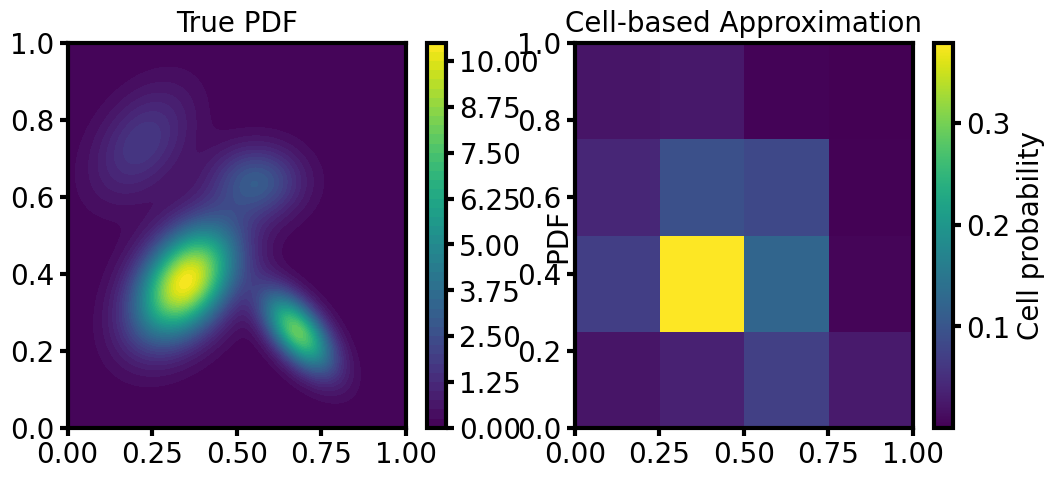

In [100]:
# --- Plot true PDF ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), levels=50, cmap='viridis')
plt.colorbar(label='PDF')
plt.title('True PDF')

# --- Plot cell approximation ---
plt.subplot(1,2,2)
approx_grid = target_probs.reshape(num_cells_x, num_cells_y).T  # transpose for correct orientation
plt.imshow(approx_grid, extent=[0,1,0,1], origin='lower', cmap='viridis', interpolation='nearest', aspect='auto')
plt.colorbar(label='Cell probability')
plt.title('Cell-based Approximation')

plt.show()

In [101]:
target_probs3 = np.zeros(num_cells_x*num_cells_y)
big_grid_x = np.linspace(x_edges[0], x_edges[-1], num_grid)
big_grid_y = np.linspace(y_edges[0], y_edges[-1], num_grid)
dx = (x_edges[-1] - x_edges[0]) / (num_grid - 1)
dy = (y_edges[-1] - y_edges[0]) / (num_grid - 1)

X, Y = np.meshgrid(big_grid_x, big_grid_y, indexing="ij")
grids = np.stack([X.ravel(), Y.ravel()], axis=-1)
pdf_vals = pdf(grids).reshape(num_grid, num_grid)

# then just slice into cells:
for i in range(num_cells_x):
    for j in range(num_cells_y):
        target_probs3[i*num_cells_y + j] = pdf_vals[
            (big_grid_x >= x_edges[i]) & (big_grid_x < x_edges[i+1])][:, 
            (big_grid_y >= y_edges[j]) & (big_grid_y < y_edges[j+1])
        ].sum() * dx * dy
print(target_probs3.sum())
target_probs /= np.sum(target_probs)

0.997979079199312


In [102]:
# integrate over the entire domain (x_edges[0], x_edges[-1]) × (y_edges[0], y_edges[-1])
big_grid_x = np.linspace(x_edges[0], x_edges[-1], 500)
big_grid_y = np.linspace(y_edges[0], y_edges[-1], 500)
dx = (x_edges[-1] - x_edges[0]) / (500 - 1)
dy = (y_edges[-1] - y_edges[0]) / (500 - 1)

X, Y = np.meshgrid(big_grid_x, big_grid_y, indexing="ij")
grids = np.stack([X.ravel(), Y.ravel()], axis=-1)

total_mass = np.sum(pdf(grids)) * dx * dy
print("Total mass of pdf over whole domain:", total_mass)

Total mass of pdf over whole domain: 0.9979780889357432


In [103]:
num_k_dim = 4
num_cells_x = num_k_dim
num_cells_y = num_k_dim
x_edges = np.linspace(0, L_list[0], num_cells_x+1)
y_edges = np.linspace(0, L_list[1], num_cells_y+1)
centroids = np.array([[(x_edges[i]+x_edges[i+1])/2, (y_edges[j]+y_edges[j+1])/2] 
                      for i in range(num_cells_x) for j in range(num_cells_y)])

target_probs2 = np.zeros(num_cells_x*num_cells_y)
num_grid = 100
for i in range(num_cells_x):
    for j in range(num_cells_y):
        x0, x1 = x_edges[i], x_edges[i+1]
        y0, y1 = y_edges[j], y_edges[j+1]
        grids_x = np.linspace(x0, x1, num_grid)
        grids_y = np.linspace(y0, y1, num_grid)
        dx = (x1 - x0) / (num_grid - 1)
        dy = (y1 - y0) / (num_grid - 1)
        #grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
        X, Y = np.meshgrid(grids_x, grids_y, indexing="ij")
        grids = np.stack([X.ravel(), Y.ravel()], axis=-1)
        target_probs2[i*num_cells_y + j] = np.sum(pdf(grids)) * dx * dy
print(target_probs2.sum())
# normalize to make sure sum=1
target_probs /= np.sum(target_probs)

1.0175071802780011


In [104]:
target_probs3, target_probs2, target_probs

(array([2.1230e-02, 7.0632e-02, 4.0255e-02, 2.1526e-02, 3.5250e-02,
        3.7872e-01, 9.2016e-02, 2.4280e-02, 7.2289e-02, 1.2314e-01,
        8.2340e-02, 3.1440e-03, 2.7042e-02, 4.4910e-03, 1.5622e-03,
        6.5108e-05]),
 array([2.2454e-02, 7.3433e-02, 4.0964e-02, 2.2505e-02, 3.6938e-02,
        3.8120e-01, 9.4057e-02, 2.4826e-02, 7.4756e-02, 1.2450e-01,
        8.3309e-02, 3.4079e-03, 2.8514e-02, 4.8977e-03, 1.6652e-03,
        7.4806e-05]),
 array([2.1246e-02, 7.0683e-02, 4.0284e-02, 2.1883e-02, 3.5276e-02,
        3.7899e-01, 9.2082e-02, 2.4683e-02, 7.2341e-02, 1.2323e-01,
        8.2399e-02, 3.1962e-03, 2.7491e-02, 4.5655e-03, 1.5881e-03,
        6.7240e-05]))

In [112]:
np.max(np.abs(target_probs - target_probs3))

0.0004489353650794191

In [66]:
print(target_probs2.sum())

1.0175071802780011


In [68]:
target_probs,target_probs2

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([2.2454e-02, 7.3433e-02, 4.0964e-02, 2.2505e-02, 3.6938e-02,
        3.8120e-01, 9.4057e-02, 2.4826e-02, 7.4756e-02, 1.2450e-01,
        8.3309e-02, 3.4079e-03, 2.8514e-02, 4.8977e-03, 1.6652e-03,
        7.4806e-05]))

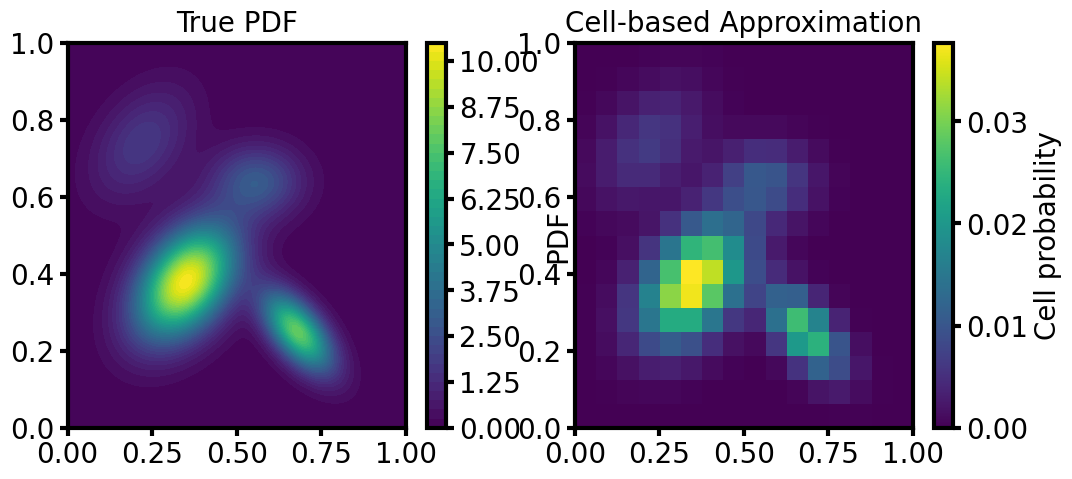

In [176]:
# --- Plot true PDF ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), levels=50, cmap='viridis')
plt.colorbar(label='PDF')
plt.title('True PDF')

# --- Plot cell approximation ---
plt.subplot(1,2,2)
approx_grid = target_probs.reshape(num_cells_x, num_cells_y).T  # transpose for correct orientation
plt.imshow(approx_grid, extent=[0,1,0,1], origin='lower', cmap='viridis', interpolation='nearest', aspect='auto')
plt.colorbar(label='Cell probability')
plt.title('Cell-based Approximation')

plt.show()

In [177]:
print(target_probs)

[1.4725e-05 5.9389e-05 1.5280e-04 2.5094e-04 2.6337e-04 1.7914e-04
 9.9205e-05 1.4355e-04 4.0724e-04 8.4576e-04 1.1306e-03 9.6569e-04
 5.2677e-04 1.8340e-04 4.0721e-05 6.0380e-06 4.4058e-05 2.1161e-04
 6.4818e-04 1.2672e-03 1.5822e-03 1.2643e-03 6.7159e-04 3.8956e-04
 7.5002e-04 1.7669e-03 2.8027e-03 2.8480e-03 1.8488e-03 7.6631e-04
 2.0266e-04 3.5736e-05 8.4126e-05 4.8110e-04 1.7541e-03 4.0813e-03
 6.0636e-03 5.7558e-03 3.5103e-03 1.5191e-03 1.1235e-03 2.3962e-03
 4.4412e-03 5.3627e-03 4.1411e-03 2.0425e-03 6.4305e-04 1.3475e-04
 1.0255e-04 6.9831e-04 3.0304e-03 8.3900e-03 1.4830e-02 1.6744e-02
 1.2087e-02 5.6632e-03 2.2011e-03 2.3051e-03 4.5299e-03 6.4556e-03
 5.9244e-03 3.4758e-03 1.3022e-03 3.2403e-04 7.9824e-05 6.4728e-04
 3.3436e-03 1.1015e-02 2.3162e-02 3.1107e-02 2.6692e-02 1.4667e-02
 5.3980e-03 2.2975e-03 3.1509e-03 5.0147e-03 5.4227e-03 3.7786e-03
 1.6839e-03 4.9730e-04 3.9660e-05 3.8310e-04 2.3561e-03 9.2373e-03
 2.3108e-02 3.6914e-02 3.7671e-02 2.4586e-02 1.0456e-02 3.5766

In [178]:
### So what this code does is estimating target measure empiricaly i.e sum of diracs and then matching those! i.e centroids

In [179]:
mu_samples = sample_from_pdf_2d(pdf, [0,1], [0,1], n_samples = 100_000)

In [180]:
# --- Dynamics & simulation ---
dt_emp = 0.01 ### Choose as the time we want i.e f:[0,t] -> X with t = dt_emp*T
tsteps = 100001
dt = 0.01 #1/tsteps            
ud = .2 #* dt_emp * tsteps 

def step(xt, ut):
    return xt + dt * ut

# --- Initialize ---
xt = np.random.uniform(low=0.0, high=1.0, size=(2,))
xt = np.array([.5,.5])
x_traj = np.zeros((tsteps, 2))
traj_counts = np.zeros_like(target_probs)
metric_log = []
divergence = []
# --- Main loop ---
for t in range(tsteps):
    # 1. Update trajectory counts
    ix = np.searchsorted(x_edges, xt[0], side='right') - 1
    iy = np.searchsorted(y_edges, xt[1], side='right') - 1
    ix = np.clip(ix, 0, num_cells_x-1)
    iy = np.clip(iy, 0, num_cells_y-1)
    cell_idx = ix*num_cells_y + iy
    traj_counts[cell_idx] += dt
    #print(target_probs)
    # 2. Compute control direction
    lambda_g = traj_counts / (((t+1) * dt))
    #print(lambda_g.sum())
    sigma = 0.05  # optional influence radius for decay
    epsilon = 1e-6
    e = target_probs - lambda_g
    e = np.maximum(0, e)
    vectors = centroids - xt  # shape (num_cells, 2)

    #dist = np.sum(vectors**2, axis=1)**0.5
    
    dist2 = np.sum(vectors**2, axis=1)

    weights = np.exp(-dist2 / sigma)
    #weights1 = np.exp(-dist / sigma)
    
    direction = np.sum(e[:, np.newaxis] * weights[:, np.newaxis] * (vectors / dist2[:, np.newaxis]), axis=0) ## dist is squared here!
    
    #direction = np.sum(e[:, np.newaxis] * weights[:, np.newaxis] * (vectors), axis=0) # sigma**(-2) can be ignored tough, as it does not change size of vecs in relation to another
    
    #direction = np.sum(e[:, np.newaxis] * weights[:, np.newaxis] * (vectors / dist[:, np.newaxis]), axis=0)#### looks resonable make sure dist is not squared!
    ut = ud * direction / (np.linalg.norm(direction) + 1e-8)

    # 3. Step dynamics
    xt = step(xt, ut)
    x_traj[t] = xt.copy()

    # 4. Compute simple ergodic metric
    metric = np.sum((target_probs - lambda_g)**2)
    metric_log.append(metric)

    # Logging every 1000 steps
    if t % 10000 == 0 and t != 0:
        print(f"Step {t}, Position: {xt[:2]}, Metric: {metric:.5f}")  
        #mu_samples = sample_from_pdf_2d(pdf, [0,1], [0,1], n_samples = x_traj[:t,:].shape[0])
        KL = im.kld(x_traj[:t,:],mu_samples[:t,:], approach='metric')
        #divergence.append(KL)
        print(KL, 'emp')



Step 10000, Position: [0.2764 0.3715], Metric: 0.00047
2.0771611025706775 emp
Step 20000, Position: [0.5308 0.5928], Metric: 0.00011
1.9324784250353013 emp
Step 30000, Position: [0.1264 0.882 ], Metric: 0.00007
1.9129706582572341 emp
Step 40000, Position: [0.3114 0.3379], Metric: 0.00004
1.8815935722830313 emp
Step 50000, Position: [0.1851 0.2826], Metric: 0.00002
1.8701759783731076 emp
Step 60000, Position: [0.5349 0.3265], Metric: 0.00003
1.9126827768749486 emp
Step 70000, Position: [0.6562 0.2805], Metric: 0.00002
1.866008997446567 emp
Step 80000, Position: [0.4797 0.4227], Metric: 0.00001
1.9651802923937103 emp
Step 90000, Position: [0.2814 0.5308], Metric: 0.00001
1.9605405971558652 emp
Step 100000, Position: [0.6548 0.2178], Metric: 0.00001
1.9627185471563977 emp


In [181]:
#np.save(r"Divergence_Data/Finite100.npy", np.array(divergence))


In [182]:
np.linalg.norm(x_traj[0] - x_traj[1])

0.001999999978425127

2025-08-21 11:21:49,200 |  WARNING | legend.py:1323 | No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


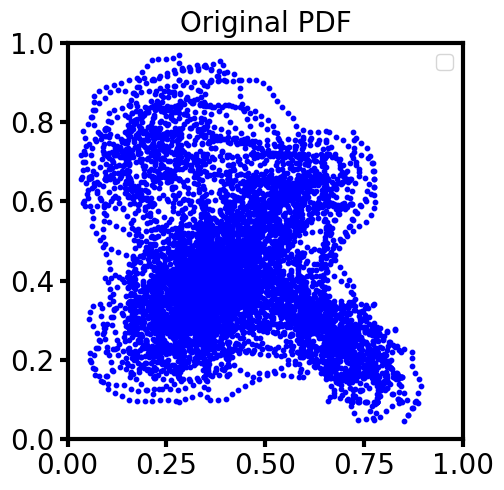

In [183]:
#mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.scatter(x_traj[::10, 0], x_traj[::10, 1], s=10, color='blue')
#ax.scatter(mu_samples[::10, 0], mu_samples[::10, 1], s=10, color='green')
ax.legend(loc=1)
plt.show()
plt.close()

In [184]:
#np.save(r"Divergence_Data/Finite.npy", np.array(divergence))

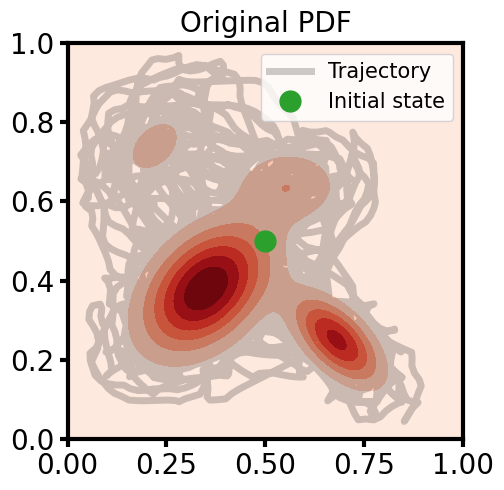

In [185]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(GX, GY, vals.reshape(ng, ng), cmap='Reds', alpha=0.6)
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds', alpha=1.)
ax.plot(x_traj[::10,0], x_traj[::10,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

plt.show()
plt.close()

In [186]:
def point_to_cell_projection(xt, x_edges, y_edges):
    """
    For a point xt = (x0,y0), compute its projection onto each cell A_ij.
    Returns:
        projections: array of shape (num_cells_x*num_cells_y, 2)
        dists2: squared distances to each cell
    """
    x0, y0 = xt
    num_cells_x = len(x_edges) - 1
    num_cells_y = len(y_edges) - 1

    projections = np.zeros((num_cells_x * num_cells_y, 2))
    dists2 = np.zeros(num_cells_x * num_cells_y)

    for i in range(num_cells_x):
        for j in range(num_cells_y):
            # bounds
            x_lo, x_hi = x_edges[i], x_edges[i+1]
            y_lo, y_hi = y_edges[j], y_edges[j+1]

            # clamp each coordinate
            px = min(max(x0, x_lo), x_hi)
            py = min(max(y0, y_lo), y_hi)

            idx = i*num_cells_y + j
            projections[idx] = [px, py]
            dists2[idx] = (px - x0)**2 + (py - y0)**2

    return projections, dists2



In [187]:
import numpy as np

def point_to_cell_projection_vec(xt, x_edges, y_edges):
    """
    Vectorized projection of point xt=(x0,y0) onto all cells in the grid.

    Returns:
        projections: (num_cells_x*num_cells_y, 2)
        dists2: (num_cells_x*num_cells_y,)
    """
    x0, y0 = xt

    # Build grid of cell bounds
    x_lo = x_edges[:-1][:, None]   # shape (num_cells_x, 1)
    x_hi = x_edges[1:][:, None]    # shape (num_cells_x, 1)
    y_lo = y_edges[:-1][None, :]   # shape (1, num_cells_y)
    y_hi = y_edges[1:][None, :]    # shape (1, num_cells_y)

    # Clamp x and y into intervals (broadcasted)
    px = np.clip(x0, x_lo, x_hi)   # (num_cells_x, 1)
    py = np.clip(y0, y_lo, y_hi)   # (1, num_cells_y)

    # Broadcast to full grid shape
    px_full = np.repeat(px, len(y_edges)-1, axis=1)   # (num_cells_x, num_cells_y)
    py_full = np.repeat(py, len(x_edges)-1, axis=0)   # (num_cells_x, num_cells_y)

    # Flatten to (num_cells,2)
    projections = np.column_stack([px_full.ravel(), py_full.ravel()])

    # Squared distances
    dists2 = (projections[:,0] - x0)**2 + (projections[:,1] - y0)**2

    return projections, dists2


In [195]:
# --- Dynamics & simulation ---
dt_emp = 0.01 ### Choose as the time we want i.e f:[0,t] -> X with t = dt_emp*T
tsteps = 100001
dt = dt_emp            
ud = .2

def step(xt, ut):
    return xt + dt * ut

# --- Initialize ---
#xt = np.random.uniform(low=0.0, high=1.0, size=(2,))
xt = np.array([.5,.5])
x_traj = np.zeros((tsteps, 2))
traj_counts = np.zeros_like(target_probs)
metric_log = []
divergence = []
# --- Main loop ---
for t in range(tsteps):
    # 1. Update trajectory counts
    ix = np.searchsorted(x_edges, xt[0], side='right') - 1
    iy = np.searchsorted(y_edges, xt[1], side='right') - 1
    ix = np.clip(ix, 0, num_cells_x-1)
    iy = np.clip(iy, 0, num_cells_y-1)
    cell_idx = ix*num_cells_y + iy
    traj_counts[cell_idx] += 1
    #print(target_probs)
    # 2. Compute control direction
    lambda_g = traj_counts / ((t+1))
    #print(lambda_g)
    sigma = 5.  # optional influence radius for decay
    epsilon = 1e-12
    e = target_probs - lambda_g
    e = np.maximum(0, e)
    centroids, _ = point_to_cell_projection_vec(xt, x_edges, y_edges)
    vectors = centroids - xt  # shape (num_cells, 2)
    dist2 = np.sum(vectors**2, axis=1) + epsilon
    weights = np.exp(-dist2 / sigma**2)
    direction = np.sum(e[:, np.newaxis] * weights[:, np.newaxis] * (vectors / dist2[:, np.newaxis]), axis=0)
    #direction = np.sum(e[:, np.newaxis] * (vectors / dist2[:, np.newaxis]), axis=0)
    ut = ud * direction / (np.linalg.norm(direction) + 1e-8)

    # 3. Step dynamics
    xt = step(xt, ut)
    x_traj[t] = xt.copy()

    # 4. Compute simple ergodic metric
    metric = np.sum((target_probs - lambda_g)**2)
    metric_log.append(metric)

    # Logging every 1000 steps
    if t % 10000 == 0 and t != 0:
        print(f"Step {t}, Position: {xt[:2]}, Metric: {metric:.5f}")  
        #mu_samples = mu_samples = sample_from_pdf_2d(pdf, [0,1], [0,1], n_samples = x_traj[:t,:].shape[0])
        KL = im.kld(x_traj[:t,:],mu_samples[:t,:], approach='metric')
        #divergence.append(KL)
        print(KL, 'emp')



Step 10000, Position: [0.6876 0.1879], Metric: 0.00115
2.6250431952893933 emp
Step 20000, Position: [0.434  0.3952], Metric: 0.00039
2.373930347208328 emp
Step 30000, Position: [0.4515 0.2507], Metric: 0.00021
2.338784555448612 emp
Step 40000, Position: [0.5418 0.5106], Metric: 0.00014
2.3472291245060033 emp
Step 50000, Position: [0.3653 0.4368], Metric: 0.00011
2.243426094800779 emp
Step 60000, Position: [0.4272 0.5449], Metric: 0.00009
2.1620386626564008 emp
Step 70000, Position: [0.1885 0.2512], Metric: 0.00008
2.1733506960029847 emp
Step 80000, Position: [0.2502 0.3125], Metric: 0.00007
2.1239708605711685 emp
Step 90000, Position: [0.5458 0.3687], Metric: 0.00006
2.140204218375324 emp
Step 100000, Position: [0.6878 0.2497], Metric: 0.00006
2.1498462703314605 emp


2025-08-21 12:41:22,976 |  WARNING | legend.py:1323 | No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


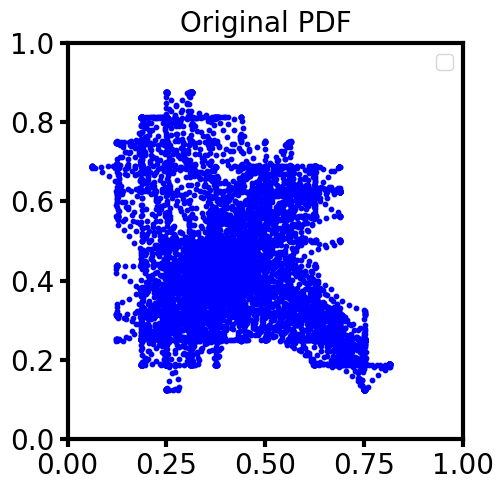

In [196]:
#mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.scatter(x_traj[::10, 0], x_traj[::10, 1], s=10, color='blue')
#ax.scatter(mu_samples[::10, 0], mu_samples[::10, 1], s=10, color='green')
ax.legend(loc=1)
plt.show()
plt.close()

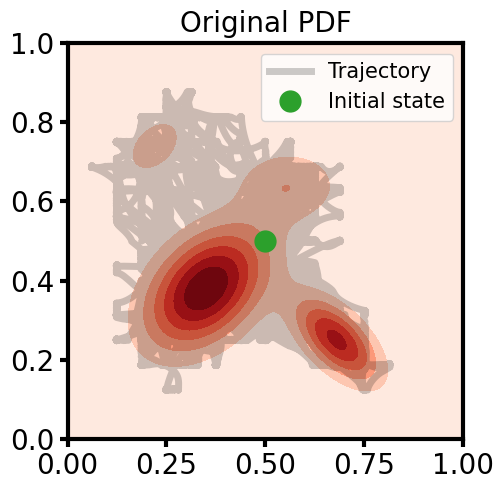

In [197]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(GX, GY, vals.reshape(ng, ng), cmap='Reds', alpha=0.6)
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds', alpha=1.)
ax.plot(x_traj[:,0], x_traj[:,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

plt.show()
plt.close()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Parameters
N = 256  # number of Voronoi cells
num_samples = 20000
mu_samples = sample_from_pdf_2d(pdf, [0,1], [0,1], n_samples = num_samples)

kmeans = KMeans(n_clusters=N, random_state=42)
kmeans.fit(mu_samples)
centroids = kmeans.cluster_centers_
labels = kmeans.predict(mu_samples)



Step 10000, pos=[0.8807 0.7422], metric=0.000632
Step 20000, pos=[0.3694 0.3854], metric=0.000282
Step 30000, pos=[0.3313 0.2981], metric=0.000219
Step 40000, pos=[0.7938 0.7098], metric=0.000103
Step 50000, pos=[0.8489 0.8466], metric=0.000082
Step 60000, pos=[0.2458 0.3429], metric=0.000046
Step 70000, pos=[0.6095 0.5958], metric=0.000036
Step 80000, pos=[0.289  0.3551], metric=0.000045
Step 90000, pos=[0.1659 0.3427], metric=0.000029
Step 100000, pos=[0.4515 0.3543], metric=0.000037


In [ ]:
num_samples = 100_000
mu_samples = sample_from_pdf_2d(pdf, [0,1], [0,1], n_samples=num_samples)

In [6]:
N_samples = 16**2
centroids = sample_from_pdf_2d(pdf, [0,1], [0,1], n_samples=N_samples)

In [7]:
N = N_samples

In [330]:
target_probs = np.ones(centroids.shape[0]) / centroids.shape[0]

2025-08-21 18:17:08,297 |  WARNING | legend.py:1323 | No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


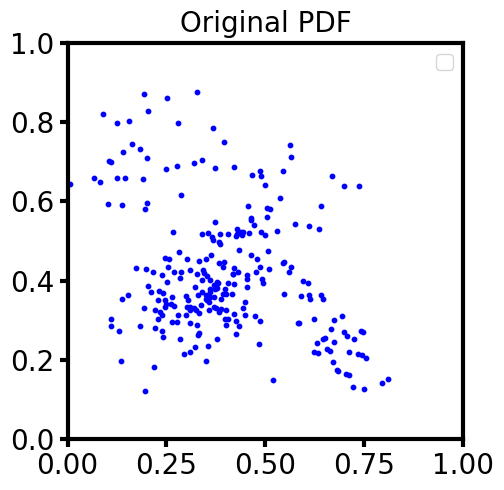

In [318]:
#mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.scatter(centroids[:, 0], centroids[:,1], s=10, color='blue')
#ax.scatter(mu_samples[::10, 0], mu_samples[::10, 1], s=10, color='green')
ax.legend(loc=1)
plt.show()
plt.close()

In [299]:
np.set_printoptions(threshold=np.inf)


Step 10000, pos=[0.3441 0.3455], metric=0.01124
Step 20000, pos=[0.4344 0.5179], metric=0.23668
Step 30000, pos=[0.4398 0.52  ], metric=0.32678
Step 40000, pos=[0.4407 0.5204], metric=0.28058
Step 50000, pos=[0.4407 0.5202], metric=0.32102
Step 60000, pos=[0.3773 0.5086], metric=0.31593
Step 70000, pos=[0.3768 0.5079], metric=0.26061
Step 80000, pos=[0.3765 0.5075], metric=0.25239
Step 90000, pos=[0.3766 0.5074], metric=0.26569
Step 100000, pos=[0.3765 0.5074], metric=0.28875


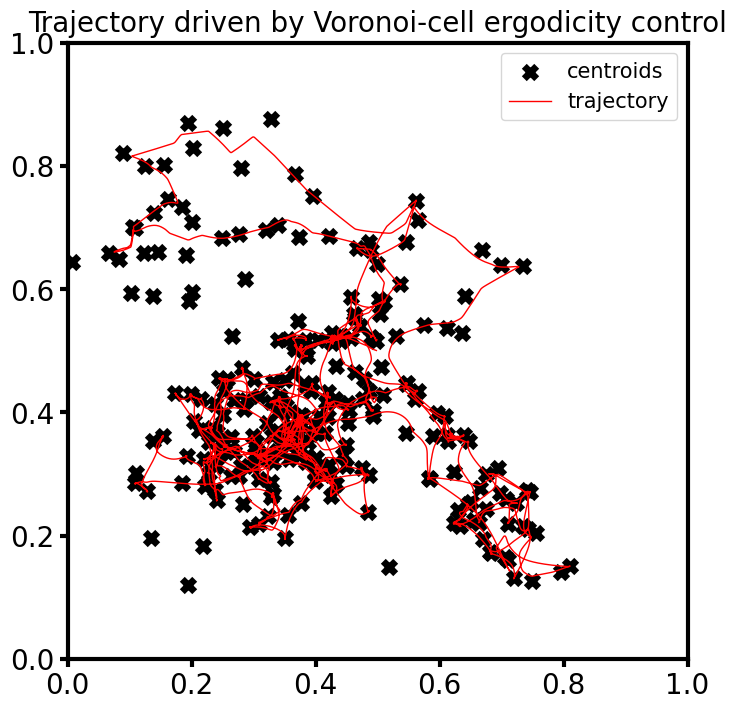

In [326]:

dt_emp = 0.01
tsteps = 100001
dt = dt_emp
ud = 0.2

def step(xt, ut):
    return xt + dt * ut

# Initialize
xt = np.array([0.5, 0.5])
x_traj = np.zeros((tsteps, 2))
traj_counts = np.zeros(N)
metric_log = []

for t in range(tsteps):
    # 1. Assign xt to nearest Voronoi centroid
    dists = np.linalg.norm(centroids - xt, axis=1)
    cell_idx = np.argmin(dists)
    traj_counts[cell_idx] += 1

    # 2. Empirical distribution
    lambda_g = traj_counts / (t+1)

    # 3. Control direction based on errors
    #e = target_probs - lambda_g
    #e = np.maximum(0, e)
    #print(np.max(lambda_g))
    e = (target_probs - lambda_g) #* centroids.shape[0]    # can be negative; we want deficits
    #print(e)
    e = np.maximum(0.0, e)  # only care about deficits
    sigma = 0.05
    epsilon = 1e-12
    vectors = centroids - xt
    dist2 = np.sum(vectors**2, axis=1)
    weights = np.exp(-dist2 / sigma**2)#
    #weights = np.ones_like(dist2)
    direction = np.sum(e[:, None] * weights[:, None] * (vectors / np.sqrt(dist2)[:, None]), axis=0)
    #print(direction)
    ut = ud * direction / (np.linalg.norm(direction) + 1e-8)

    # 4. Step dynamics
    xt = step(xt, ut)
    x_traj[t] = xt.copy()

    # 5. Metric
    metric = np.sum((target_probs - lambda_g)**2)
    metric_log.append(metric)

    if t % 10000 == 0 and t != 0:
        print(f"Step {t}, pos={xt}, metric={metric:.5f}")

# --- Visualization ---
plt.figure(figsize=(8,8))
#plt.scatter(mu_samples[:,0], mu_samples[:,1], c=labels, cmap="tab20", s=5, alpha=0.3)
plt.scatter(centroids[:,0], centroids[:,1], c="black", marker="x", s=80, label="centroids")
plt.plot(x_traj[:,0], x_traj[:,1], c="red", linewidth=1, label="trajectory")
plt.legend()
plt.title("Trajectory driven by Voronoi-cell ergodicity control")
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()


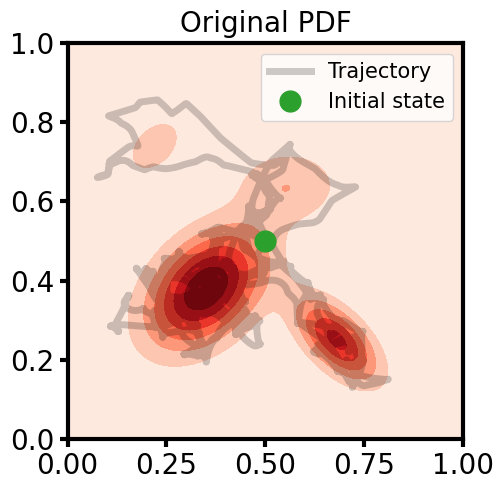

In [327]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(GX, GY, vals.reshape(ng, ng), cmap='Reds', alpha=0.6)
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds', alpha=1.)
ax.plot(x_traj[:,0], x_traj[:,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

plt.show()
plt.close()

In [262]:
im.kld(x_traj[:t,:],mu_samples[:t,:], approach='metric')


1.6700922578289124

In [311]:
# Replace the relevant block inside your loop with this (keeps everything else)

# precompute a lengthscale once after centroids exist:
from scipy.spatial import cKDTree
kdt = cKDTree(centroids)
dists_nn, _ = kdt.query(centroids, k=2)  # k=2: first neighbor is itself at distance 0
median_nn = np.median(dists_nn[:,1])     # median nearest-neighbor distance
# choose sigma relative to this scale
base_sigma = 0.6 * median_nn   # tune 0.4-1.0
print(base_sigma)

dt_emp = 0.01
tsteps = 100001
dt = dt_emp
ud = 0.2

def step(xt, ut):
    return xt + dt * ut

# Initialize
xt = np.array([0.5, 0.5])
x_traj = np.zeros((tsteps, 2))
traj_counts = np.zeros(N)
metric_log = []
idx = 100
for t in range(tsteps):# 1. Assign xt to nearest Voronoi centroid (keep for counts)
    dists = np.linalg.norm(centroids - xt, axis=1)
    cell_idx = np.argmin(dists)
    traj_counts[cell_idx] += 1

    # 2. Empirical distribution
    lambda_g = traj_counts / (t + 1.0)

    # 3. Normalized/relative error [](avoids vanishing signal)
    eps = 1e-12
    rel_err = (target_probs - lambda_g) #* centroids.shape[0]   # can be negative; we want deficits
    rel_err = np.maximum(0.0, rel_err)  # only care about deficits


    # 5. adaptive sigma depending on distance scaling
    sigma = 0.1#base_sigma
    vectors = centroids[:idx] - xt    # (k,2)
    dists_top = np.linalg.norm(vectors, axis=1) + 1e-12

    # 6. weights: use soft gaussian on normalized distances, then apply relative error
    weights = np.exp(-(dists_top**2) / (2 * sigma**2))
    weights = weights / weights.sum()
    # directional unit vectors
    unit = vectors / dists_top[:, None]

    # weighted sum (amplify by relative error)
    err_top = rel_err[:idx]
    direction = (err_top[:, None] * weights[:, None] * unit).sum(axis=0)


    ut = ud * direction / (np.linalg.norm(direction) + 1e-12)
    xt = step(xt, ut)
    x_traj[t] = xt.copy()

    if t % 10000 == 0 and t != 0:
        print(f"Step {t}, pos={xt}, metric={metric:.5f}")
        idx *= 10


0.002413578533383385
Step 10000, pos=[0.3543 0.3596], metric=0.13355
Step 20000, pos=[0.3394 0.3838], metric=0.13355
Step 30000, pos=[0.3509 0.3799], metric=0.13355
Step 40000, pos=[0.3511 0.3801], metric=0.13355
Step 50000, pos=[0.3512 0.3803], metric=0.13355
Step 60000, pos=[0.3513 0.3804], metric=0.13355
Step 70000, pos=[0.3514 0.3805], metric=0.13355
Step 80000, pos=[0.3515 0.3805], metric=0.13355
Step 90000, pos=[0.3515 0.3806], metric=0.13355
Step 100000, pos=[0.3516 0.3806], metric=0.13355


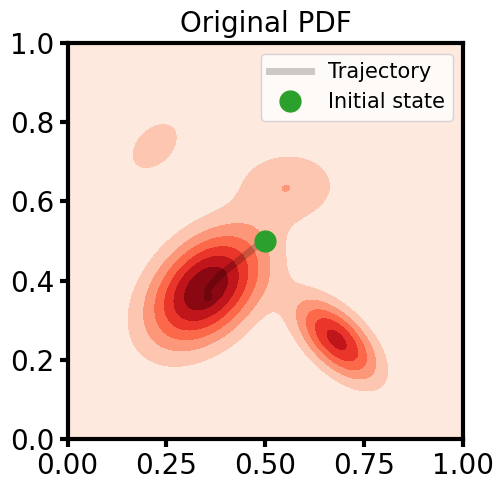

In [310]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(GX, GY, vals.reshape(ng, ng), cmap='Reds', alpha=0.6)
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds', alpha=1.)
ax.plot(x_traj[:,0], x_traj[:,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

plt.show()
plt.close()

In [314]:
num_samples = 50_000
mu_samples = sample_from_pdf_2d(pdf, [0,1], [0,1], n_samples=num_samples)

Step 5000, pos=[0.4566 0.4212], metric=0.001691
Step 10000, pos=[0.3674 0.3392], metric=0.000490
Step 5000, pos=[0.3935 0.4943], metric=0.984015
Step 10000, pos=[0.3935 0.4943], metric=0.987004


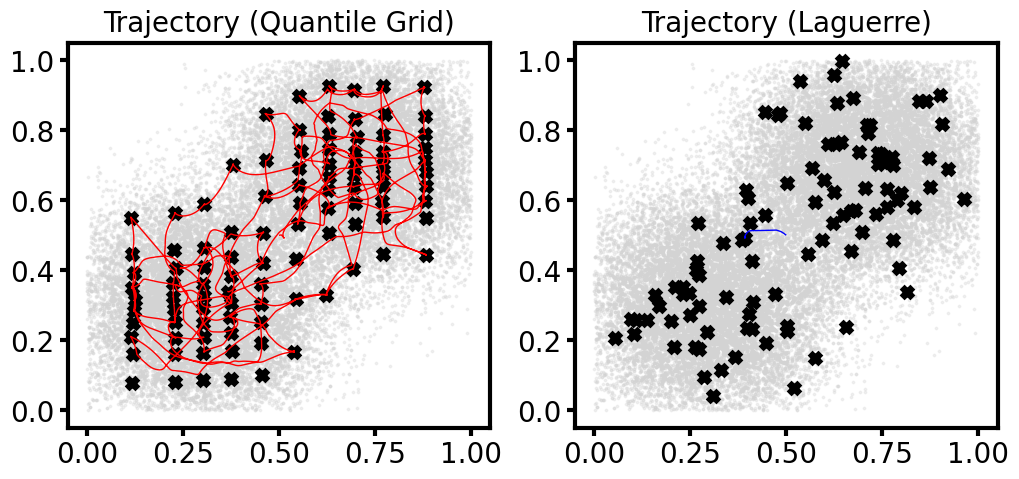

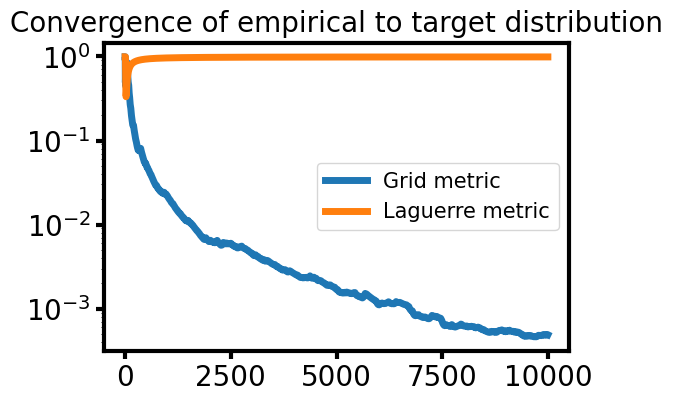

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree


def equal_mass_grid(samples, n_x, n_y):
    xs = np.sort(samples[:,0])
    x_edges = np.quantile(xs, np.linspace(0,1,n_x+1))
    cells = []
    centroids = []
    edges_y_all = []

    for i in range(n_x):
        mask_x = (samples[:,0] >= x_edges[i]) & (samples[:,0] < x_edges[i+1]) if i < n_x-1 else \
                 (samples[:,0] >= x_edges[i]) & (samples[:,0] <= x_edges[i+1])
        col = samples[mask_x]
        ys = np.sort(col[:,1])
        y_edges = np.quantile(ys, np.linspace(0,1,n_y+1))
        edges_y_all.append(y_edges)
        for j in range(n_y):
            mask_y = (col[:,1] >= y_edges[j]) & (col[:,1] < y_edges[j+1]) if j < n_y-1 else \
                     (col[:,1] >= y_edges[j]) & (col[:,1] <= y_edges[j+1])
            block = col[mask_y]
            if len(block)==0:
                cx = 0.5*(x_edges[i]+x_edges[i+1])
                cy = 0.5*(y_edges[j]+y_edges[j+1])
            else:
                cx, cy = block.mean(axis=0)
            centroids.append([cx, cy])
    centroids = np.array(centroids)
    target_probs = np.full(len(centroids), 1.0/len(centroids))
    return x_edges, edges_y_all, centroids, target_probs

def cell_index_grid(x, x_edges, edges_y_all, n_x, n_y):
    i = np.searchsorted(x_edges, x[0], side="right") - 1
    i = min(max(i,0), n_x-1)
    y_edges = edges_y_all[i]
    j = np.searchsorted(y_edges, x[1], side="right") - 1
    j = min(max(j,0), n_y-1)
    return i*n_y + j

# =====================================================
# 2B. Partition strategy B: Laguerre / Power diagram
# =====================================================
def balance_laguerre_weights(samples, centroids, target_mass, iters=100, eta=0.5):
    N = len(centroids)
    w = np.zeros(N)
    for _ in range(iters):
        d2 = ((samples[:,None,:] - centroids[None,:,:])**2).sum(axis=2) - w[None,:]
        assign = np.argmin(d2, axis=1)
        counts = np.bincount(assign, minlength=N)
        mass_emp = counts / len(samples)
        w += eta * (target_mass - mass_emp)
    return w

def cell_index_laguerre(x, centroids, w):
    d2 = ((centroids - x)**2).sum(axis=1) - w
    return np.argmin(d2)

# =====================================================
# 3. Control loop (works with either partition)
# =====================================================
def run_control(centroids, target_probs, assign_func, dt=0.01, tsteps=10001, ud=0.2):
    N = len(centroids)
    eps = 1e-12

    # Precompute scale for sigma
    kdt = cKDTree(centroids)
    dists_nn, _ = kdt.query(centroids, k=2)
    median_nn = np.median(dists_nn[:,1])
    base_sigma = 0.05

    xt = np.array([0.5, 0.5], dtype=float)
    x_traj = np.zeros((tsteps, 2))
    traj_counts = np.zeros(N, dtype=float)
    metric_log = []
    ut_prev = np.zeros(2)
    beta = 0.8

    for t in range(tsteps):
        # 1) assign
        cell_idx = assign_func(xt)
        traj_counts[cell_idx] += 1

        # 2) empirical distribution
        lambda_g = traj_counts / (t+1.0)

        # 3) relative deficits
        e = (target_probs - lambda_g)
        rel_err = np.maximum(e, 0.0)

        # 5) distance weights
        vec = centroids - xt
        r = np.linalg.norm(vec, axis=1)**2
        unit = vec / (r[:,None] + eps)
        weights = np.exp(-(r**2)/(2*base_sigma**2))
        weights = weights / (weights.sum() + eps)

        # 6) direction
        d = (rel_err[:,None] * weights[:,None] * unit).sum(axis=0)

        # 7) control with momentum
        ut = ud * d / (np.linalg.norm(d)+eps)
        
        # 8) update state
        xt = xt + dt * ut
        xt = np.clip(xt,0,1)
        x_traj[t] = xt

        # 9) metric
        metric = np.sum((target_probs - lambda_g)**2)
        metric_log.append(metric)

        if t % 5000 == 0 and t!=0:
            print(f"Step {t}, pos={xt}, metric={metric:.6f}")
    return x_traj, metric_log

# =====================================================
# 4. Run both partition strategies
# =====================================================

# --- A) Quantile grid ---
n_x, n_y = 10, 10   # total cells = n_x*n_y
x_edges, edges_y_all, centroids_grid, target_probs_grid = equal_mass_grid(mu_samples, n_x, n_y)
assign_grid = lambda x: cell_index_grid(x, x_edges, edges_y_all, n_x, n_y)
traj_grid, metric_grid = run_control(centroids_grid, target_probs_grid, assign_grid)

# --- B) Laguerre ---
N = 100
centroids_lag = mu_samples[np.random.choice(len(mu_samples), size=N, replace=False)]
target_probs_lag = np.full(N, 1.0/N)
w = balance_laguerre_weights(mu_samples, centroids_lag, target_probs_lag)
assign_lag = lambda x: cell_index_laguerre(x, centroids_lag, w)
traj_lag, metric_lag = run_control(centroids_lag, target_probs_lag, assign_lag)

# =====================================================
# 5. Visualization
# =====================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(mu_samples[:,0], mu_samples[:,1], c="lightgray", s=3, alpha=0.3)
plt.scatter(centroids_grid[:,0], centroids_grid[:,1], c="black", marker="x", s=60)
plt.plot(traj_grid[:,0], traj_grid[:,1], c="red", lw=1)
plt.title("Trajectory (Quantile Grid)")

plt.subplot(1,2,2)
plt.scatter(mu_samples[:,0], mu_samples[:,1], c="lightgray", s=3, alpha=0.3)
plt.scatter(centroids_lag[:,0], centroids_lag[:,1], c="black", marker="x", s=60)
plt.plot(traj_lag[:,0], traj_lag[:,1], c="blue", lw=1)
plt.title("Trajectory (Laguerre)")

plt.show()

plt.figure(figsize=(6,4))
plt.plot(metric_grid, label="Grid metric")
plt.plot(metric_lag, label="Laguerre metric")
plt.yscale("log")
plt.legend()
plt.title("Convergence of empirical to target distribution")
plt.show()
